In [1]:
import numpy as np
np.random.seed(10)
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding,RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, RFE

In [2]:
#skin dataset - 3 features and 1 target
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
skin_data_raw = pd.read_csv(url,sep='\t',names=['x1','x2','x3','target'])

In [3]:
print(skin_data_raw['target'].unique())
skin_data_raw['target']=skin_data_raw['target'].map({1:0,2:1})
skin_data_raw.head()

[1 2]


,x1,x2,x3,target
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [4]:
skin_data_raw['target'].unique()

array([0, 1], dtype=int64)

In [5]:
len(skin_data_raw['x1'].unique())

256

In [6]:
X = skin_data_raw.values[:,:3]
y = skin_data_raw.values[:,3]

In [7]:
#X_test,y_test used for final model evaluation
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)
#creating a second subset of the training_data for the second model in the ensamble (logit)
X_train_rf, X_train_lr, y_train_rf, y_train_lr = train_test_split(X_train,y_train,test_size=0.5,random_state=0)

In [18]:
from tree_feature_transformation_v2 import TreeTransformClf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators':10,
          'max_depth':3}
rf_lm2 = TreeTransformClf(RandomForestClassifier,n_estimators=20,max_depth=5,logit_C=0.1)
rf_lm2.fit(X_train,y_train)

5


In [25]:
pipeline = Pipeline([('scaling',StandardScaler()),
                     ('classification',TreeTransformClf(RandomForestClassifier,n_estimators=20,max_depth=5,logit_C=0.1))])

5


In [26]:
pipeline.fit(X_train,y_train)

C:\Users\bnedanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', <tree_feature_transformation_v2.TreeTransformClf object at 0x000001C807F2AB00>)])

In [29]:
pipeline = Pipeline([('scaling',StandardScaler()),
                     ('feat_selection',feature_selector),
                     ('classification',TreeTransformClf())])

In [30]:
#feature selection
feature_selector = SelectKBest()

pipeline = Pipeline([('scaling',StandardScaler()),
                     ('feat_selection',feature_selector),
                     ('classification',TreeTransformClf())])

param_grid = {'feat_selection__k':[1,2,3],
              'classification__logit_C':[0.1,1.0,10],
              'classification__max_depth':[3,5,8]}

#print(param_grid)

gs = GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring='f1',n_jobs=-1,verbose=1,cv=5)

In [31]:
gs.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


PicklingError: Can't pickle <class 'tree_feature_transformation_v2.TreeTransformClf'>: it's not the same object as tree_feature_transformation_v2.TreeTransformClf

In [28]:
rf_lm2.predict(X_test)

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [29]:
rf_pred = rf_lm2.predict_proba(X_test)[:,1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, rf_pred)

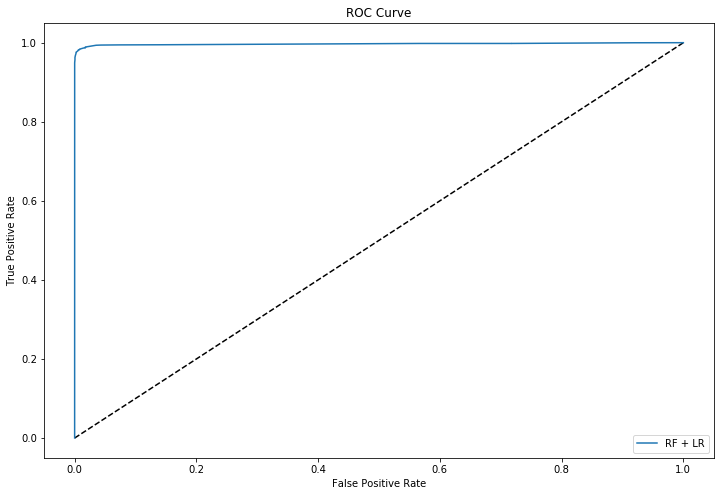

In [30]:
#plotting the results
plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()